# About

In [1]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

Text about organization of our code and this notebook

# Prerequisites 

(tbd) This notebook assumes that you:

- have internet access
- have a Google identity
- have configured a project under Google Cloud Platform (you can see how to complete this step in this tutorial)
- replace ##MY_PROJECT_ID## in the cell below with the ID of the GCP project you have confugured under your account

In [2]:
my_project_id = "idc-pathomics-000"

# Environment setup

In [3]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /home/jupyter/idc-pathomics-use-case-1/src
Hostname          : idc-patho-vm
Username          : jupyter


In [26]:
!sudo apt-get update
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install -r ../requirements_cptac.txt # at the end, check whether all are required, maybe no requirement file needed, when only one/two things are installed
!pip install wandb -qqq # monitoring tool 

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease                            
Hit:3 http://deb.debian.org/debian buster-updates InRelease                    
Hit:4 http://deb.debian.org/debian buster-backports InRelease                  
Hit:5 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease
Hit:6 https://download.docker.com/linux/debian buster InRelease                
Hit:7 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease
Hit:8 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease
Hit:9 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease
Hit:11 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:12 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Get:10 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Hit:13 http://packages.cloud.google.c

In [4]:
# Import all required python libraries for this use case
import os
import sys
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide can not be loaded. Maybe find a better solution?!
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import wandb

In [5]:
# Create directories for input and output data 
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'
#os.mkdir(input_dir)
#os.mkdir(output_dir)

# Dataset selection and exploration

## Dataset selection using BigQuery

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `tbd` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place. Additional information on the organization of data can be found in the [IDC Documentation](https://learn.canceridc.dev/data/organization-of-data). 

The easiest way to acess BigQuery tables from within a Jupyter notebook is to use the [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) provided by the BigQuery client library for Python. 
Using the `%%bigquery` command as shown below, the results of the following SQL query are stored as pandas data frame `cohort_df`.   
Further information on how to use BigQuery within the IDC, on the attributes available and examples can be found [here](https://learn.canceridc.dev/cookbook/bigquery). 

In [8]:
%%bigquery cohort_df --project=$my_project_id 

WITH slide_images AS (
    SELECT
        ContainerIdentifier AS slide_id,
        PatientID AS patient_id,
        ClinicalTrialProtocolID AS dataset,
        TotalPixelMatrixColumns AS width,
        TotalPixelMatrixRows AS height,
        gcs_url,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
        CASE TransferSyntaxUID
            WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
            WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
            ELSE 'other'
        END AS compression
    FROM idc-dev-etl.idc_v3.dicom_all
    WHERE NOT (ContainerIdentifier IS NULL)
)
SELECT *
FROM slide_images
WHERE
    (compression = "jpeg")
    AND (dataset = "CPTAC-LUAD" OR dataset = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2211/2211 [00:01<00:00, 1444.15rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract those from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. 

In [19]:
from data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv(os.path.join(input_dir, 'tissue_type_data_TCIA.csv'))
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv for later use

## Dataset exploration 

Using pandas and matplotlib functionality the user can quite easily have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [18]:
print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'luad']) 
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'lscc'])
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

slides_metadata.head()

Total number of slides in this cohort:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


,slide_id,patient_id,cancer_subtype,tissue_type,width,height,gcs_url,pixel_spacing,compression
0,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,luad,tumor,55775,48446,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg
1,C3L-00095-26,C3L-00095,luad,normal,27887,24718,gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc42...,0.000494,jpeg
2,C3L-00412-21,C3L-00412,luad,tumor,33863,32867,gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4...,0.000494,jpeg
3,C3L-00568-23,C3L-00568,lscc,tumor,19919,18390,gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c...,0.000494,jpeg
4,C3L-00893-21,C3L-00893,luad,tumor,19919,19138,gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096...,0.000494,jpeg


Having ~1000 slides from ~200 patients for each cancer subtype, means that there are on average 5 WSI per patient. The left plot below provides more detailed information in form of a histogram. 

**Important:** From almost every patient (LUAD or LSCC), not only tumor tissue but both tumor tissue and healthy ("normal") tissue samples were collected. The right graph below reveals that in LUAD and LSCC, about one-third of the slides were derived from healthy tissue, while the other two-thirds were derived from cancer tissue. 

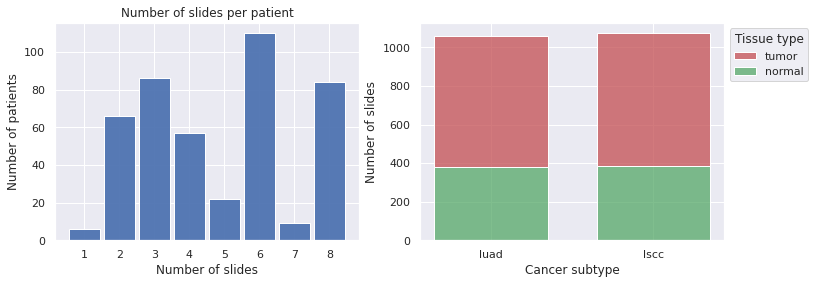

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# How many slides per patient? --> maybe also distinguish between luad and lscc pattients
slides_per_patient = slides_metadata.groupby(['patient_id', 'cancer_subtype']).size()
ax1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9)
ax1.set_title('Number of slides per patient')
ax1.set_xlabel('Number of slides')
ax1.set_ylabel('Number of patients')

# Displaying tissue type distribution 
#print(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
plot = sns.histplot(data=slides_metadata, x='cancer_subtype', hue='tissue_type', palette=['r','g'], multiple='stack', ax=ax2, shrink=0.7)
ax2.set_xlabel('Cancer subtype')
ax2.set_ylabel('Number of slides')
legend = plot.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

In [ ]:
# IDC viewer for some pathomics data? 
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/" + study_UID

# Pathomics use case

In this use case, we solve a typical pathomics classification task by training a model to reliably distinguish between healthy tissue, LUAD tissue and LSCC tissue. 

(maybe show three tiles / another image from Coudray? / give sources / show workflow image)

## Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` and the respective "gcs_url"s. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. \
Note that only the tiles are permanently stored on disk and the WSI are deleted, since these are no longer required. 

**Generation of datasets**: Next, the tiles are distributed among (sorted into) training, test and validation datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file is created that reports the number of tiles created for each patient and is used to generate the figure below. \
As this code is supposed to serve as a demo requiring a minimum amount of runtime, we reduce each datasets size by taking only one in ten/twenty tiles. 

In [6]:
from data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
#os.makedir(slides_dir)
#os.makedir(tiles_dir)

#generate_tiles(slides_dir, os.path.join(input_dir, 'slides_metadata.csv'), tiles_dir, 'idc-pathomics-000')
#os.remove(slides_dir) # delete because this directory is now empty and no longer required

In [24]:
from data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_luad_lscc')

Total number of tiles: 3,592,912


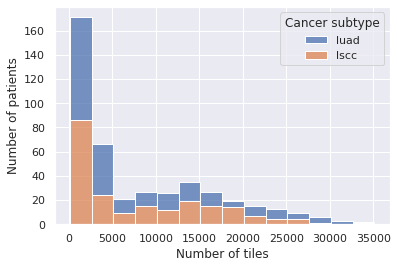

In [27]:
# How many tiles per patient (due to different size of slides)?
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

ax = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', binwidth=2500)
ax.set_xlabel('Number of tiles')
ax.set_ylabel('Number of patients')
legend = ax.get_legend()
legend.set_title('Cancer subtype')

In [20]:
# Create smaller training / validation and test sets (1/10 of the tiles)
!sed -n '1p;0~20p' "$input_dir/train_norm_luad_lscc.csv" > "$input_dir/train_norm_luad_lscc_smaller.csv"
!sed -n '1p;0~20p' "$input_dir/valid_norm_luad_lscc.csv" > "$input_dir/valid_norm_luad_lscc_smaller.csv"
!sed -n '1p;0~20p' "$input_dir/test_norm_luad_lscc.csv" > "$input_dir/test_norm_luad_lscc_smaller.csv"

## Training

explanatory text, checkpoints are saved (only when validation loss improves?!, InceptionV3 (as used in Coudray) 

In [14]:
wandb.login()
run = wandb.init()

wandb: Currently logged in as: daniela_ (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-08-12 12:45:24.368442: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-12 12:45:25.283690: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer.so.7
2021-08-12 12:45:25.285421: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer_plugin.so.7


In [15]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_smaller.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_smaller.csv'), num_classes=3)
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.01)
#print(model)

model.train(dataset_train, batch_size=128, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid) 
### change to only store best validation loss 


InvalidVersionSpec: Invalid version '1.0<2': invalid character(s)



Train for 974 steps, validate for 217 steps
Epoch 1/10
973/974 [============================>.] - ETA: 0s - loss: 0.7966 - auc: 0.8494

2021-08-12 12:51:18.087606: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_001/assets
974/974 [==============================] - 360s 370ms/step - loss: 0.7966 - auc: 0.8494 - val_loss: 0.9207 - val_auc: 0.8666
Epoch 2/10
973/974 [============================>.] - ETA: 0s - loss: 0.6421 - auc: 0.8905

2021-08-12 12:56:22.567098: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_002/assets
974/974 [==============================] - 349s 358ms/step - loss: 0.6420 - auc: 0.8905 - val_loss: 1.1391 - val_auc: 0.8344
Epoch 3/10
973/974 [============================>.] - ETA: 0s - loss: 0.5771 - auc: 0.9092

2021-08-12 13:02:11.883323: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_003/assets
974/974 [==============================] - 350s 359ms/step - loss: 0.5772 - auc: 0.9092 - val_loss: 0.6327 - val_auc: 0.8898
Epoch 4/10
973/974 [============================>.] - ETA: 0s - loss: 0.5352 - auc: 0.9213

2021-08-12 13:08:02.563577: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_004/assets
974/974 [==============================] - 349s 358ms/step - loss: 0.5352 - auc: 0.9213 - val_loss: 0.6888 - val_auc: 0.8817
Epoch 5/10
973/974 [============================>.] - ETA: 0s - loss: 0.5059 - auc: 0.9295

2021-08-12 13:13:51.527077: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_005/assets
974/974 [==============================] - 351s 360ms/step - loss: 0.5059 - auc: 0.9295 - val_loss: 0.6441 - val_auc: 0.8954
Epoch 6/10
973/974 [============================>.] - ETA: 0s - loss: 0.4809 - auc: 0.9360

2021-08-12 13:19:42.218349: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_006/assets
974/974 [==============================] - 350s 360ms/step - loss: 0.4810 - auc: 0.9359 - val_loss: 0.6102 - val_auc: 0.9050
Epoch 7/10
973/974 [============================>.] - ETA: 0s - loss: 0.4621 - auc: 0.9408

2021-08-12 13:25:32.612034: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_007/assets
974/974 [==============================] - 350s 359ms/step - loss: 0.4620 - auc: 0.9408 - val_loss: 0.6476 - val_auc: 0.8993
Epoch 8/10
973/974 [============================>.] - ETA: 0s - loss: 0.4409 - auc: 0.9461

2021-08-12 13:31:22.143129: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_008/assets
974/974 [==============================] - 350s 360ms/step - loss: 0.4409 - auc: 0.9461 - val_loss: 0.5898 - val_auc: 0.9108
Epoch 9/10
973/974 [============================>.] - ETA: 0s - loss: 0.4223 - auc: 0.9505

2021-08-12 13:37:12.654802: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_009/assets
974/974 [==============================] - 352s 361ms/step - loss: 0.4223 - auc: 0.9505 - val_loss: 0.5940 - val_auc: 0.9059
Epoch 10/10
973/974 [============================>.] - ETA: 0s - loss: 0.4067 - auc: 0.9540

2021-08-12 13:43:04.817140: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/checkpoint_010/assets
974/974 [==============================] - 353s 362ms/step - loss: 0.4067 - auc: 0.9540 - val_loss: 0.6348 - val_auc: 0.9071


2021-08-12 13:44:06.487963: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2021-08-12 13:44:06.490816: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210812_124529/trained_model/assets


In [9]:
run.finish()

## Evaluation

explanatory text, explain ROC analysis? micro average...

In [35]:
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 

#best_model = '/home/jupyter/idc_output/20210812_124529'
best_model = InceptionModel.load(best_model_dir)

/home/jupyter/idc_output/20210812_124529
/home/jupyter/idc_output/20210812_124529/checkpoint_010/


In [29]:
from evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_tiny.csv'), num_classes=3)
predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_testset.json'))

0 C3L-00913-22
1 C3L-00913-22
2 C3L-00913-22
3 C3L-00913-22
4 C3L-00913-22
5 C3L-00913-22
6 C3L-00913-22
7 C3L-00913-22
8 C3L-00913-22
9 C3L-00913-22
10 C3L-00913-22
11 C3L-00913-22
12 C3L-00913-22
13 C3L-00913-22
14 C3L-00913-22
15 C3L-00913-22
16 C3L-00913-22
17 C3L-00913-22
18 C3L-00913-22
19 C3L-00913-22
20 C3L-00913-22
21 C3L-00913-22
22 C3L-00913-22
23 C3L-00913-22
24 C3L-00913-22
25 C3L-00913-22
26 C3L-00913-22
27 C3L-00913-22
28 C3L-00913-22
29 C3L-00913-22
30 C3L-00913-22
31 C3L-00913-22
32 C3L-00913-22
33 C3L-00913-22
34 C3L-00913-22
35 C3L-00913-22
36 C3L-00913-22
37 C3L-00913-22
38 C3L-00913-22
39 C3L-00913-22
40 C3L-00913-22
41 C3L-00913-22
42 C3L-00913-22
43 C3L-00913-22
44 C3L-00913-22
45 C3L-00913-22
46 C3L-00913-22
47 C3L-00913-22
48 C3L-00913-22
49 C3L-00913-22
50 C3L-00913-22
51 C3L-00913-22
52 C3L-00913-22
53 C3L-00913-22
54 C3L-00913-22
55 C3L-00913-22
56 C3L-00913-22
57 C3L-00913-22
58 C3L-00913-22
59 C3L-00913-22
60 C3L-00913-22
61 C3L-00913-22
62 C3L-00913-22
63

In [30]:
from evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions, experiment='norm_luad_lusc')
roc_analysis.plot(output_dir_experiment) # make an inline plot
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table.html'))

        slide_id reference_value                     average_probability  \
0   C3N-02090-23               1   [0.10392992, 0.83393043, 0.062139515]   
1   C3N-02143-24               1    [0.25963026, 0.6926745, 0.047694832]   
2   C3L-04334-23               2    [0.11322513, 0.49215156, 0.39462328]   
3   C3L-04759-23               1     [0.06144756, 0.6260394, 0.31251305]   
4   C3L-00973-28               0   [0.75727445, 0.15588929, 0.086836204]   
5   C3N-01023-27               0     [0.7644546, 0.20767678, 0.02786887]   
6   C3N-02088-26               0    [0.78631115, 0.20210317, 0.01158579]   
7   C3L-04880-27               0   [0.80182344, 0.016754696, 0.18142188]   
8   C3L-00913-22               1     [0.068349466, 0.5121511, 0.4194993]   
9   C3N-00580-24               1  [0.121508755, 0.79486203, 0.083629236]   
10  C3L-02219-22               1    [0.08780093, 0.83421296, 0.07798625]   
11  C3L-04873-21               2  [0.106783435, 0.0133337425, 0.8798828]   
12  C3L-0404

In [ ]:
from evaluation.heatmap import Heatmap 

colormaps=['coolwarm', 'coolwarm', 'coolwarm']
hm = Heatmap(predictions, 'xxx', colormaps)
hm.plot(os.path.join(output_dir_experiment, 'heatmap.png'))

## Notes for improvement
- vielleicht ueberall funktionsparameter benennen zur besseren verstaendlichkeit**
- suppress warnings that we don't want the user to see all the time
- State some final remarks in this notebook? 